<a href="https://colab.research.google.com/github/Akhmadkhan/TPU/blob/main/SC2021_Baseline_Time_Series_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [34]:
! pip install catboost

In [45]:
import pathlib
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
DATA_DIR = pathlib.Path(".")
DATA_FILE = "/content/drive/MyDrive/TPU/sc2021_train_deals.csv"
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]
RS = 82736
# GROUPS = 941 # Number of "material-company-country-region-manager" groups

# Загрузка данных

In [38]:
data = pd.read_csv(DATA_DIR.joinpath(DATA_FILE), parse_dates=["month", "date"])
data.head()

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0


In [39]:
group_ts = data.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0)
group_ts

month                                                                  2018-01-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              340.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956               60.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-02-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              340.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942               20.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956               60.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-03-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              260.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301               30.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-04-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              240.0   
133           0            Белоруссия Минская обл.       10942              200.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301               30.0   
...                                                                           ...   
98

In [40]:
group_ts.index[0]

(124, 7278, 'Россия', 'Респ. Татарстан', 17460)

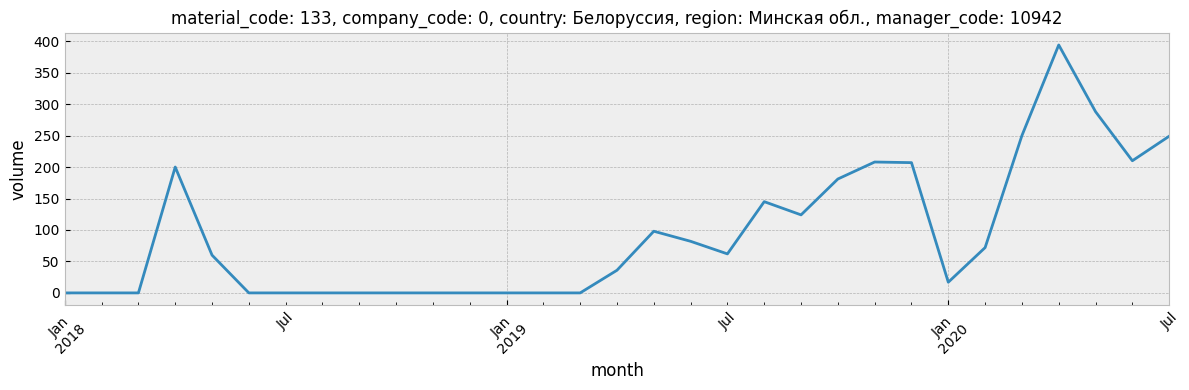

In [58]:
ROW_ID = 1
plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)
title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")
plt.tight_layout()

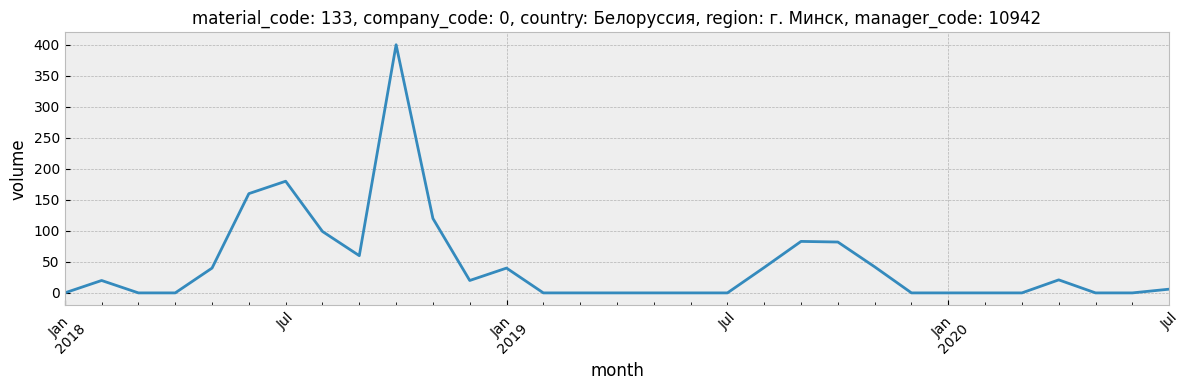

In [59]:
ROW_ID = 3
plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)
title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")
plt.tight_layout()

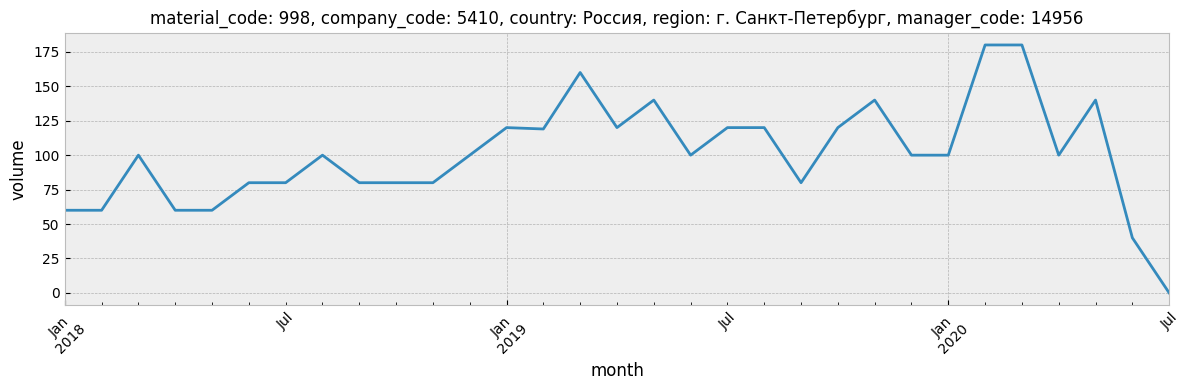

In [61]:
ROW_ID = -2
plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)
title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")
plt.tight_layout()

По умолчанию, для каждого целевого месяца резервируются предыдущие 12 месяцев для генерации признаков.

In [62]:
target_full_range = pd.date_range("2019-01-01", "2020-07-01", freq="MS")

# Baseline #1: последнее известное значение

In [63]:
tr_data = group_ts.iloc[:, :-6]
val_data = group_ts.iloc[:, :-6]
val_data

month                                                                  2018-01-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              340.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956               60.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-02-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              340.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942               20.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956               60.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-03-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              260.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301               30.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-04-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              240.0   
133           0            Белоруссия Минская обл.       10942              200.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301               30.0   
...                                                                           ...   
98

In [64]:
predictions = val_data.copy()
predictions.iloc[:, :] = np.nan
predictions.iloc[:, 0] = tr_data.iloc[:, -1]
predictions.ffill(axis=1, inplace=True)
predictions

month                                                                  2018-01-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942               17.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                5.0   
              3380         Россия     Ленинградская обл. 14956               73.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737               40.0   

month                                                                  2018-02-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942               17.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                5.0   
              3380         Россия     Ленинградская обл. 14956               73.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737               40.0   

month                                                                  2018-03-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942               17.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                5.0   
              3380         Россия     Ленинградская обл. 14956               73.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737               40.0   

month                                                                  2018-04-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942               17.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
98

In [65]:
print("Ошибка на валидационном множество:", f"{np.sqrt(mean_squared_log_error(val_data, predictions))}")

Ошибка на валидационном множество: 2.604410427111956


# Baseline #2: среднее за последние три месяца

In [66]:
predictions = val_data.copy()
predictions.iloc[:, :] = np.nan
predictions.iloc[:, 0] = tr_data.iloc[:, -3:].mean(axis=1)
predictions.ffill(axis=1, inplace=True)
predictions

month                                                                  2018-01-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460           0.000000   
133           0            Белоруссия Минская обл.       10942         144.000000   
                                      Могилевская обл.   10942           0.000000   
                                      г. Минск           10942          14.000000   
                           Казахстан  г. Нур-Султан      13301          31.666667   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460           0.000000   
998           0            Россия     Ленинградская обл. 18079           3.666667   
              3380         Россия     Ленинградская обл. 14956          68.000000   
              5410         Россия     г. Санкт-Петербург 14956         113.333333   
              6346         Россия     Респ. Башкортостан 10737          40.000000   

month                                                                  2018-02-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460           0.000000   
133           0            Белоруссия Минская обл.       10942         144.000000   
                                      Могилевская обл.   10942           0.000000   
                                      г. Минск           10942          14.000000   
                           Казахстан  г. Нур-Султан      13301          31.666667   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460           0.000000   
998           0            Россия     Ленинградская обл. 18079           3.666667   
              3380         Россия     Ленинградская обл. 14956          68.000000   
              5410         Россия     г. Санкт-Петербург 14956         113.333333   
              6346         Россия     Респ. Башкортостан 10737          40.000000   

month                                                                  2018-03-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460           0.000000   
133           0            Белоруссия Минская обл.       10942         144.000000   
                                      Могилевская обл.   10942           0.000000   
                                      г. Минск           10942          14.000000   
                           Казахстан  г. Нур-Султан      13301          31.666667   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460           0.000000   
998           0            Россия     Ленинградская обл. 18079           3.666667   
              3380         Россия     Ленинградская обл. 14956          68.000000   
              5410         Россия     г. Санкт-Петербург 14956         113.333333   
              6346         Россия     Респ. Башкортостан 10737          40.000000   

month                                                                  2018-04-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460           0.000000   
133           0            Белоруссия Минская обл.       10942         144.000000   
                                      Могилевская обл.   10942           0.000000   
                                      г. Минск           10942          14.000000   
                           Казахстан  г. Нур-Султан      13301          31.666667   
...                                                                           ...   
98

In [67]:
print("Ошибка на валидационном множество:", f"{np.sqrt(mean_squared_log_error(val_data, predictions))}")

Ошибка на валидационном множество: 2.3542398727110867


# Baseline #3: CatBoostRegressor

Признаки:

- оригинальные категориальные признаки,
- месяц, для которого предсказываем,
- среднее, минимум и максимум за год,
- последние 6 месяцев до месяца, для которого предсказываем.

In [68]:
def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Calculate features for `month`."""

    start_period = month - pd.offsets.MonthBegin(6)
    end_period = month - pd.offsets.MonthBegin(1)

    df = df.loc[:, :end_period]

    features = pd.DataFrame([], index=df.index)
    features['month'] = month.month
    features[[f"vol_tm{i}" for i in range(6, 0, -1)]] = df.loc[:, start_period:end_period].copy()

    rolling = df.rolling(12, axis=1, min_periods=1)
    features = features.join(rolling.mean().iloc[:, -1].rename('last_year_avg'))
    features = features.join(rolling.min().iloc[:, -1].rename('last_year_min'))
    features = features.join(rolling.max().iloc[:, -1].rename('last_year_max'))
    return features

In [71]:
tr_range = pd.date_range("2019-01-01", "2019-06-01", freq="MS" )
val_range = pd.date_range("2019-07-01", "2019-12-01", freq="MS" )
ts_range = pd.date_range("2019-01-01", "2019-07-01", freq="MS" )
full_features = {}
for dataset, dataset_range in zip(["tr", "val", "ts"], [tr_range, val_range, ts_range]):
  dataset_features = []
  for target_month in dataset_range:
    features = get_features(group_ts, target_month)
    features['target'] = group_ts[target_month]
    dataset_features.append(features.reset_index())
  full_features[dataset] = pd.concat(dataset_features, ignore_index=True)
CAT_COLS = ['material_code', 'company_code', 'country', 'region', 'manager_code', 'month']
FTS_COLS = ['material_code', 'company_code', 'country', 'region', 'manager_code', 'month',
            'vol_tm6', 'vol_tm5', 'vol_tm4', 'vol_tm3', 'vol_tm2', 'vol_tm1',
            'last_year_avg', 'last_year_min', 'last_year_max']
TARGET = 'target'
full_features["tr"][FTS_COLS].head()

,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,last_year_min,last_year_max
0,124,7278,Россия,Респ. Татарстан,17460,1,220.0,220.0,220.0,280.0,280.0,280.0,260.000000,220.0,340.0
1,133,0,Белоруссия,Минская обл.,10942,1,0.0,0.0,0.0,0.0,0.0,0.0,21.666667,0.0,200.0
2,133,0,Белоруссия,Могилевская обл.,10942,1,0.0,0.0,100.0,220.0,20.0,0.0,40.000000,0.0,220.0
3,133,0,Белоруссия,г. Минск,10942,1,180.0,99.0,60.0,400.0,120.0,20.0,91.583333,0.0,400.0
4,133,0,Казахстан,г. Нур-Султан,13301,1,40.0,20.0,40.0,30.0,0.0,40.0,19.166667,0.0,40.0


In [72]:
full_features["val"][FTS_COLS].head()

,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,last_year_min,last_year_max
0,124,7278,Россия,Респ. Татарстан,17460,7,200.0,200.0,200.0,185.0,103.0,62.0,204.166667,62.0,280.0
1,133,0,Белоруссия,Минская обл.,10942,7,0.0,0.0,0.0,36.0,98.0,82.0,18.000000,0.0,98.0
2,133,0,Белоруссия,Могилевская обл.,10942,7,0.0,80.0,142.0,103.0,145.0,0.0,67.500000,0.0,220.0
3,133,0,Белоруссия,г. Минск,10942,7,40.0,0.0,0.0,0.0,0.0,0.0,76.583333,0.0,400.0
4,133,0,Казахстан,г. Нур-Султан,13301,7,40.0,50.0,0.0,40.0,0.0,40.0,28.333333,0.0,50.0


In [74]:
model = CatBoostRegressor(
 cat_features=CAT_COLS,
 random_state=RS,
 eval_metric="MSLE",
 iterations=100,
 learning_rate=0.15,
 depth=12,
 l2_leaf_reg=45,
 model_size_reg=2,
 diffusion_temperature=40
 )

model.fit(full_features["tr"][FTS_COLS], full_features["tr"][TARGET],
          eval_set=(full_features["val"][FTS_COLS], full_features["val"][TARGET]))

0:	learn: 8.2672336	test: 6.8466330	best: 6.8466330 (0)	total: 177ms	remaining: 17.5s
1:	learn: 7.8390047	test: 6.5119198	best: 6.5119198 (1)	total: 288ms	remaining: 14.1s
2:	learn: 7.4201230	test: 6.1789697	best: 6.1789697 (2)	total: 403ms	remaining: 13s
3:	learn: 7.0837183	test: 5.9259323	best: 5.9259323 (3)	total: 513ms	remaining: 12.3s
4:	learn: 6.7524537	test: 5.6722485	best: 5.6722485 (4)	total: 626ms	remaining: 11.9s
5:	learn: 6.4227219	test: 5.4214111	best: 5.4214111 (5)	total: 756ms	remaining: 11.8s
6:	learn: 6.1973152	test: 5.2719301	best: 5.2719301 (6)	total: 872ms	remaining: 11.6s
7:	learn: 5.9656270	test: 5.1123720	best: 5.1123720 (7)	total: 984ms	remaining: 11.3s
8:	learn: 5.7220081	test: 4.9374865	best: 4.9374865 (8)	total: 1.1s	remaining: 11.1s
9:	learn: 5.5284634	test: 4.8066645	best: 4.8066645 (9)	total: 1.2s	remaining: 10.8s
10:	learn: 5.3689991	test: 4.7029030	best: 4.7029030 (10)	total: 1.32s	remaining: 10.7s
11:	learn: 5.2074686	test: 4.5952450	best: 4.5952450 (11

In [75]:
pd.Series(model.feature_importances_, index=FTS_COLS).sort_values(ascending=False)

vol_tm2          31.306338
vol_tm1          30.010472
last_year_max    10.473239
vol_tm6           6.243079
vol_tm4           6.175743
vol_tm3           5.722979
last_year_avg     4.702278
last_year_min     4.442610
vol_tm5           0.923262
material_code     0.000000
company_code      0.000000
country           0.000000
region            0.000000
manager_code      0.000000
month             0.000000
dtype: float64

In [76]:
tr_preds = model.predict(full_features["tr"][FTS_COLS])
val_preds = model.predict(full_features["val"][FTS_COLS])
ts_preds = model.predict(full_features["ts"][FTS_COLS])

In [77]:
print("Ошибка на тренеровочном множество:",
      f'{np.sqrt(mean_squared_log_error(full_features["tr"][TARGET], tr_preds)): .4f}')
print("Ошибка на валидационном множество:",
      f'{np.sqrt(mean_squared_log_error(full_features["val"][TARGET], val_preds)): .4f}')
print("Ошибка на тестовом множество:",
      f'{np.sqrt(mean_squared_log_error(full_features["ts"][TARGET], ts_preds)): .4f}')

Ошибка на тренеровочном множество:  1.9409
Ошибка на валидационном множество:  1.9097
Ошибка на тестовом множество:  1.9305
